Fitting 6 folds for each of 48 candidates, totalling 288 fits

✅ Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 200, 'reg_lambda': 1.0, 'subsample': 0.8}

📊 Full GridSearchCV Results (sorted by F1_macro_mean):

F1_macro: 0.8686 ± 0.0312 → {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 200, 'reg_lambda': 1.0, 'subsample': 0.8}
F1_macro: 0.8676 ± 0.0265 → {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 200, 'reg_lambda': 1.0, 'subsample': 0.8}
F1_macro: 0.8656 ± 0.0338 → {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'reg_lambda': 1.0, 'subsample': 0.8}
F1_macro: 0.8645 ± 0.0315 → {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 300, 'reg_lambda': 1.0, 'subsample': 0.8}
F1_macro: 0.8642 ± 0.0311 → {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 400, 'reg_lambda': 1

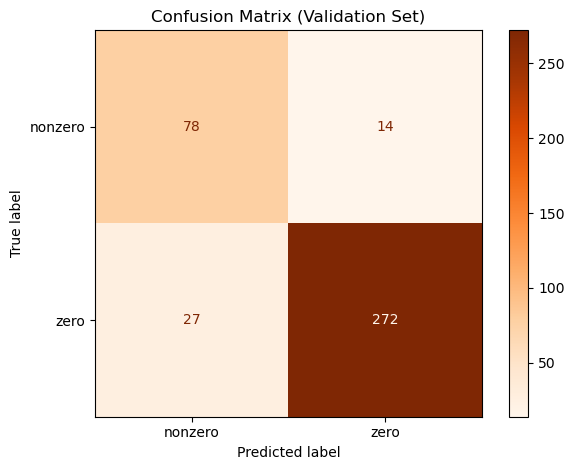

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

# === 1. Load dataset ===
df = pd.read_csv("MAGNDATA_WithBinaryKVector_Merged.csv")

# === 2. Parse elements ===
def parse_elements(val):
    if pd.isna(val): return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]
df["elements"] = df["elements"].apply(parse_elements)

# === 3. Extract crystal system ===
def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str): return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"
df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

# === 4. Numerical features and drop missing ===
numerical_features = ["cbm", "vbm", "energy_above_hull", "band_gap", "density_atomic",
                      "numberofelements", "volume", "nsites", "density", "efermi", "formation_energy_per_atom"]
df = df.dropna(subset=numerical_features + ["k_vector_label"])

# === 5. Encode elements ===
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(df["elements"]), columns=mlb.classes_)

# === 6. Encode crystal system ===
crystal_df = pd.get_dummies(df["crystal_system"], prefix="crysys")

# === 7. Combine features ===
X = pd.concat([
    df[numerical_features].reset_index(drop=True),
    element_df.reset_index(drop=True),
    crystal_df.reset_index(drop=True)
], axis=1)

# === 8. Encode target ===
le = LabelEncoder()
y = le.fit_transform(df["k_vector_label"])

# === 9. Train/Val/Test Split (90/10) → (75/25/10)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# === 10. GridSearchCV setup ===
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [6, 10, 15, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_lambda': [1.0]
}

cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        verbosity=0
    ),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# === 11. Fit GridSearchCV ===
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_
print(f"\n✅ Best Parameters: {grid_search.best_params_}\n")

# === 12. Print CV scores for all trials ===
cv_results = grid_search.cv_results_
mean_scores = cv_results['mean_test_score']
std_scores = cv_results['std_test_score']
params = cv_results['params']

print("📊 Full GridSearchCV Results (sorted by F1_macro_mean):\n")
cv_df = pd.DataFrame({
    "F1_macro_mean": mean_scores,
    "F1_macro_std": std_scores,
    "Params": params
}).sort_values(by="F1_macro_mean", ascending=False)

for i, row in cv_df.iterrows():
    print(f"F1_macro: {row['F1_macro_mean']:.4f} ± {row['F1_macro_std']:.4f} → {row['Params']}")

# === 13. CV score of best estimator ===
cv_score_best = cross_val_score(best_xgb, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
print("\n✅ Cross-validation scores for best estimator:")
print(f"Scores: {cv_score_best}")
print(f"Mean: {cv_score_best.mean():.4f}, Std: {cv_score_best.std():.4f}")

# === 14. Validation evaluation ===
y_pred_val = best_xgb.predict(X_val)
print("\n📊 Validation Report:")
print(classification_report(y_val, y_pred_val, target_names=le.classes_))

ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val, display_labels=le.classes_, cmap="Oranges", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()




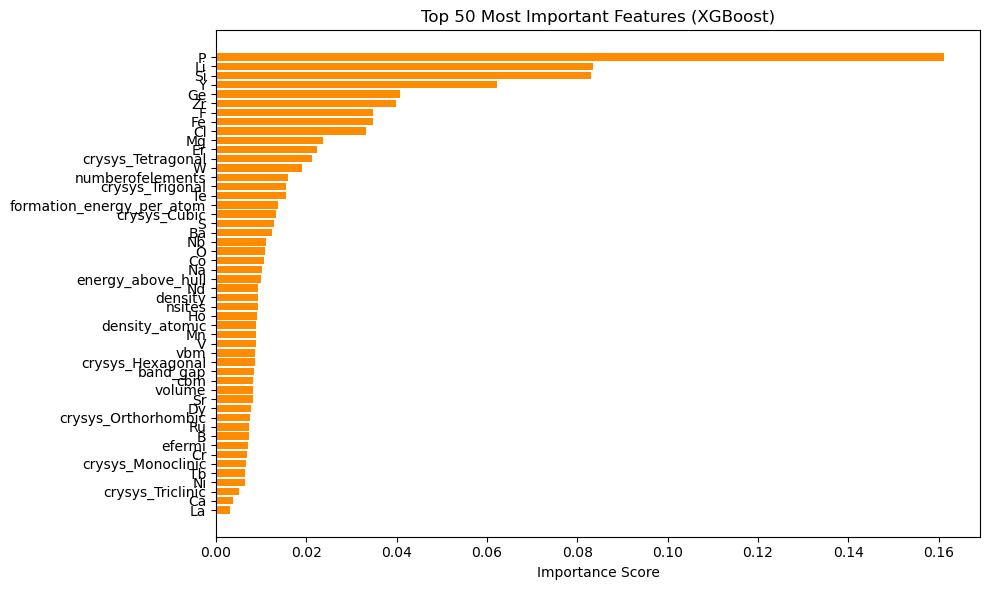

In [3]:
# === 16. Feature Importance from XGBoost ===
importances = best_xgb.feature_importances_
feature_names = X.columns

# Build DataFrame
feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

top_n = 50
top_features = feat_df.head(top_n)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"][::-1], top_features["Importance"][::-1], color="darkorange")
plt.xlabel("Importance Score")
plt.title(f"Top {top_n} Most Important Features (XGBoost)")
plt.tight_layout()
plt.show()


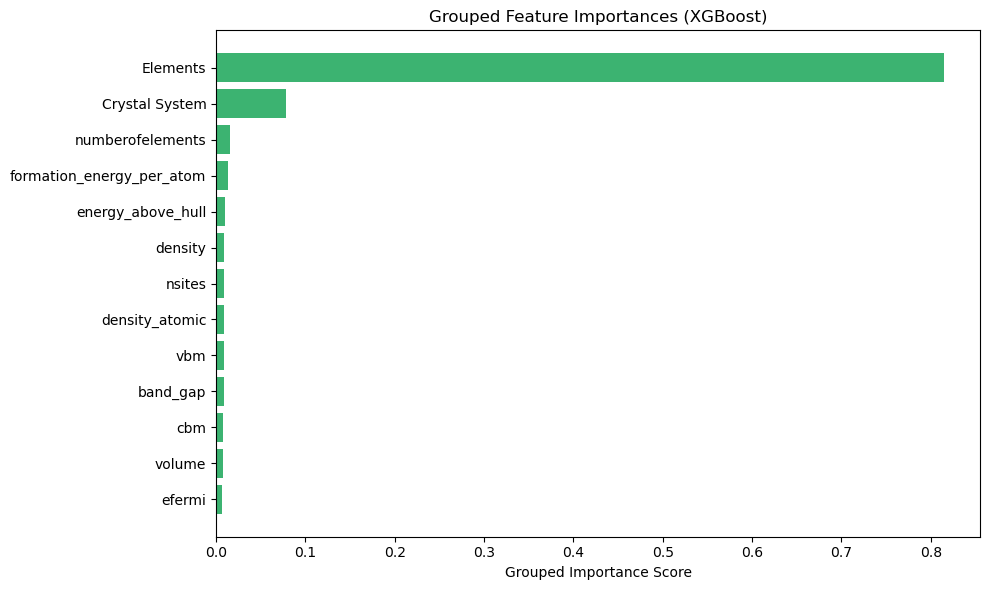

In [4]:
# === 16. Grouped Feature Importances ===
importances = best_xgb.feature_importances_
feature_names = X.columns

# Tag feature groups
group_labels = []
for feat in feature_names:
    if feat in numerical_features:
        group_labels.append(feat)  # keep individual numerical features
    elif feat in mlb.classes_:
        group_labels.append("Elements")
    elif feat.startswith("crysys_"):
        group_labels.append("Crystal System")
    else:
        group_labels.append("Other")

# Build raw DataFrame
feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances,
    "Group": group_labels
})

# Sum grouped features (except numerical ones)
numerical_set = set(numerical_features)
numerical_df = feat_df[feat_df["Group"].isin(numerical_set)][["Feature", "Importance"]].rename(columns={"Feature": "Group"})
grouped_df = feat_df[~feat_df["Group"].isin(numerical_set)].groupby("Group", as_index=False)["Importance"].sum()

# Combine
final_df = pd.concat([numerical_df, grouped_df])
final_df = final_df.sort_values("Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(final_df["Group"][::-1], final_df["Importance"][::-1], color="mediumseagreen")
plt.xlabel("Grouped Importance Score")
plt.title("Grouped Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import re
from sklearn.preprocessing import MultiLabelBinarizer

# === 1. Load both datasets ===
all_data = pd.read_csv("All Data Imported.csv")
magndata = pd.read_csv("MAGNDATA_WithBinaryKVector_Merged.csv")

# === 2. Standardize formula columns ===
all_data["formula"] = all_data["formula"].str.strip()
magndata["formula"] = magndata["formula"].str.strip()

# === 3. Filter out seen materials ===
filtered_df = all_data[~all_data["formula"].isin(magndata["formula"])].copy()
print(f"✅ Filtered dataset has {len(filtered_df)} materials after removing seen ones.")

# === 4. Define utility functions ===
def parse_elements(val):
    if pd.isna(val): return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]

def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str): return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"

# === 5. Feature Engineering ===
filtered_df["elements"] = filtered_df["elements"].apply(parse_elements)
filtered_df["crystal_system"] = filtered_df["symmetry"].apply(extract_crystal_system)

# Drop rows with missing numerical data
numerical_features = ["cbm", "vbm", "energy_above_hull", "band_gap", "density_atomic",
                      "numberofelements", "volume", "nsites", "density", "efermi", "formation_energy_per_atom"]
filtered_df = filtered_df.dropna(subset=numerical_features)

# One-hot encode
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(filtered_df["elements"]), columns=mlb.classes_)
crystal_df = pd.get_dummies(filtered_df["crystal_system"], prefix="crysys")

# Combine features
X_filtered = pd.concat([
    filtered_df[numerical_features].reset_index(drop=True),
    element_df.reset_index(drop=True),
    crystal_df.reset_index(drop=True)
], axis=1)

# Align features with training columns (X)
missing_cols = [col for col in X.columns if col not in X_filtered.columns]
for col in missing_cols:
    X_filtered[col] = 0
X_filtered = X_filtered[X.columns]  # reorder to match training set

# === 6. Predict with trained XGBoost model ===
y_pred_filtered = best_xgb.predict(X_filtered)
predicted_labels = le.inverse_transform(y_pred_filtered)

# Add predictions to DataFrame
filtered_df["Predicted Propagation Vector"] = predicted_labels

# Save to file
filtered_df.to_csv("Unseen_Data_With_Predicted_Propagation_Vector XGBoost.csv", index=False)
print("✅ Saved predictions to 'Unseen_Data_With_Predicted_Propagation_Vector XGBoost.csv'")


✅ Filtered dataset has 153067 materials after removing seen ones.
✅ Saved predictions to 'Unseen_Data_With_Predicted_Propagation_Vector XGBoost.csv'


In [8]:
import pandas as pd

# Load the unseen prediction file
df = pd.read_csv("Unseen_Data_With_Predicted_Propagation_Vector XGBoost.csv")

# Filter: predicted nonzero and ordering FM
fm_nonzero_df = df[
    (df["Predicted Propagation Vector"] == "nonzero") &
    (df["ordering"] == "FM")
]

# Show result summary
print(f"🔍 Number of materials with Predicted nonzero k-vector and FM ordering: {len(fm_nonzero_df)}")
print(fm_nonzero_df[["formula", "ordering", "Predicted Propagation Vector"]].head())

# Save to new CSV
fm_nonzero_df.to_csv("Unseen_FM_with_nonzero_k_vector_prediction XGBoost.csv", index=False)
print("✅ Saved to 'Unseen_FM_with_nonzero_k_vector_prediction XGBoost.csv'")


🔍 Number of materials with Predicted nonzero k-vector and FM ordering: 12719
            formula ordering Predicted Propagation Vector
112         Al2NiO4       FM                      nonzero
489   Al7Cr(Bi2O9)2       FM                      nonzero
629           AlVF5       FM                      nonzero
1124     Ba2MgNiWO6       FM                      nonzero
1239      Ba2GdNbO6       FM                      nonzero
✅ Saved to 'Unseen_FM_with_nonzero_k_vector_prediction XGBoost.csv'
